### Student Information
Name:

Student ID:

GitHub ID:

---

### Instructions

### First Phase Submission

1. First: do the **take home** exercises in the [DM2025-Lab1-Master](https://github.com/leoson-wu/DM2025-Lab1-Exercise/blob/main/DM2025-Lab1-Master.ipynb) that considered as **phase 1 (from exercise 1 to exercise 15)**. You can answer in the master file. __This part is worth 10% of your grade.__


2. Second: follow the same process from the [DM2025-Lab1-Master](https://github.com/leoson-wu/DM2025-Lab1-Exercise/blob/main/DM2025-Lab1-Master.ipynb) on **the new dataset** up **until phase 1**. You can skip some exercises if you think some steps are not necessary. However main exercises should be completed. You don't need to explain all details as we did (some **minimal comments** explaining your code are useful though).  __This part is worth 15% of your grade.__
    -  Use [the new dataset](https://github.com/leoson-wu/DM2025-Lab1-Exercise/blob/main/newdataset/Reddit-stock-sentiment.csv). The dataset contains a 16 columns including 'text' and 'label', with the sentiment labels being: 1.0 is positive, 0.0 is neutral and -1.0 is negative. You can simplify the dataset and use only the columns that you think are necessary. 
    
    - You are allowed to use and modify the `helper` functions in the folder of the first lab session (notice they may need modification) or create your own.
    - Use this file to complete the homework from the second part. Make sure the code can be run from the beginning till the end and has all the needed output.


3. Third: please attempt the following tasks on **the new dataset**. __This part is worth 10% of your grade.__
    - Generate meaningful **new data visualizations**. Refer to online resources and the Data Mining textbook for inspiration and ideas. 
    


4. Fourth: It's hard for us to follow if your code is messy, so please **tidy up your notebook** and **add minimal comments where needed**. __This part is worth 5% of your grade.__

You can submit your homework following these guidelines: [DM2025-Lab1-announcement](https://github.com/leoson-wu/DM2025-Lab1-Announcement/blob/main/README.md). Make sure to commit and save your changes to your repository __BEFORE the deadline (September 28th 11:59 pm, Sunday)__. 

### Second Phase Submission 

**You can keep the answer for phase 1 for easier running and update the phase 2 on the same page.**

1. First: Continue doing the **take home** exercises in the [DM2025-Lab1-Master](https://github.com/leoson-wu/DM2025-Lab1-Exercise/blob/main/DM2025-Lab1-Master.ipynb) for **phase 2, starting from Finding frequent patterns**. Use the same master(.ipynb) file. Answer from phase 1 will not be considered at this stage. You can answer in the master file. __This part is worth 10% of your grade.__


2. Second: Continue from first phase and do the same process from the [DM2025-Lab1-Master](https://github.com/leoson-wu/DM2025-Lab1-Exercise/blob/main/DM2025-Lab1-Master.ipynb) on **the new dataset** for phase 2, starting from Finding frequent pattern. You can skip some exercises if you think some steps are not necessary. However main exercises should be completed. You don't need to explain all details as we did (some **minimal comments** explaining your code are useful though).  __This part is worth 15% of your grade.__
    - Continue using this file to complete the homework from the second part. Make sure the code can be run from the beginning till the end and has all the needed output. Use the same new dataset as in phase 1.
    
    - You are allowed to use and modify the `helper` functions in the folder of the first lab session (notice they may need modification) or create your own.

3. Third: please attempt the following tasks on **the new dataset**. __This part is worth 20% of your grade.__
    - Use this file to answer.
    - Generate **TF-IDF features** from the tokens of each text. This will generating a document matrix, however, the weights will be computed differently (using the TF-IDF value of each word per document as opposed to the word frequency).  Refer to this Scikit-learn [guide](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) .
    - Implement a simple **Naive Bayes classifier** that automatically classifies the records into their categories. Use both the TF-IDF features and word frequency features to build two seperate classifiers. Note that for the TF-IDF features you might need to use other type of NB classifier different than the one in the Master Notebook. Comment on the differences and when using augmentation with feature pattern.  Refer to this [article](https://hub.packtpub.com/implementing-3-naive-bayes-classifiers-in-scikit-learn/).


4. Fourth: In the lab, we applied each step really quickly just to illustrate how to work with your dataset. There are somethings that are not ideal or the most efficient/meaningful. Each dataset can be handled differently as well. What are those inefficent parts you noticed? How can you improve the Data preprocessing for these specific datasets? __This part is worth 10% of your grade.__


5. Fifth: It's hard for us to follow if your code is messy, so please **tidy up your notebook** and **add minimal comments where needed**. __This part is worth 5% of your grade.__


You can submit your homework following these guidelines: [DM2025-Lab1-announcement](https://github.com/leoson-wu/DM2025-Lab1-Announcement/blob/main/README.md). Make sure to commit and save your changes to your repository __BEFORE the deadline (October 19th 11:59 pm, Sunday)__. 

# Phase 1

Rows after cleaning: 389
Label distribution:
 label
-1.0    115
 0.0    212
 1.0     62
Name: count, dtype: int64


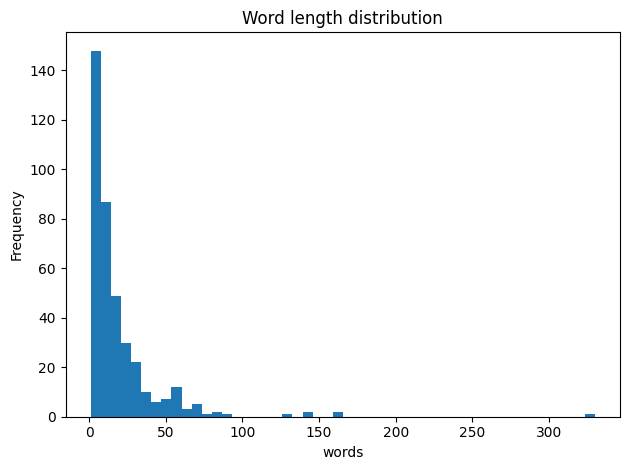

Reddit doc-term shape: (389, 219)


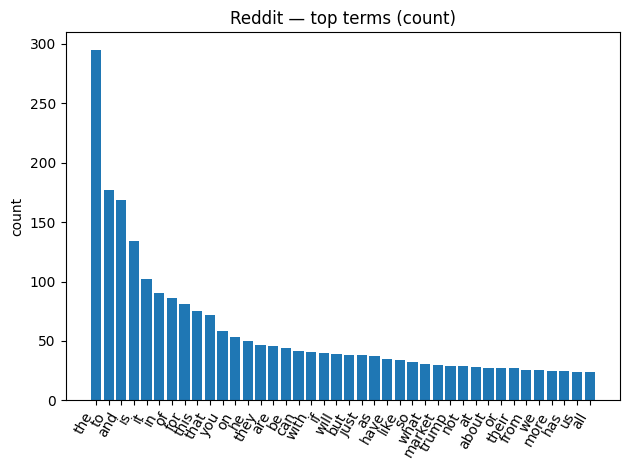

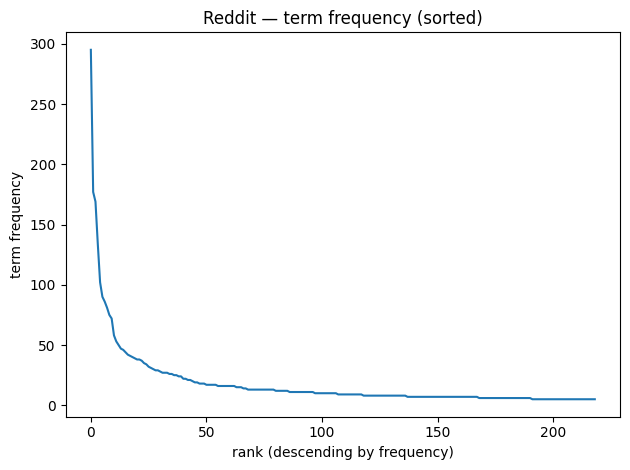

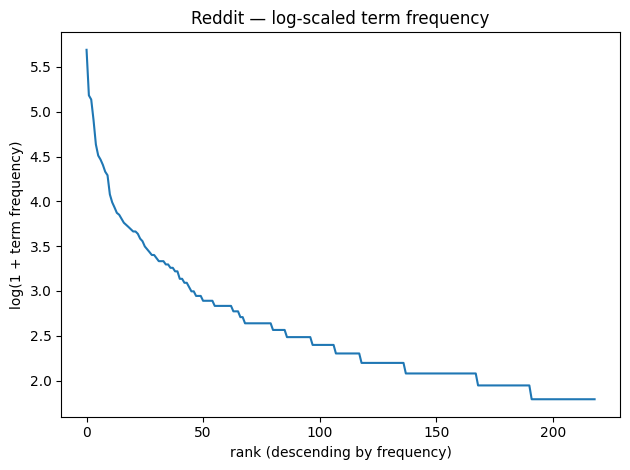

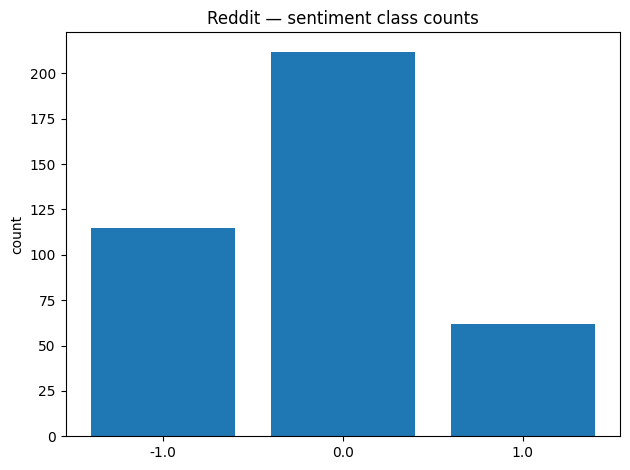

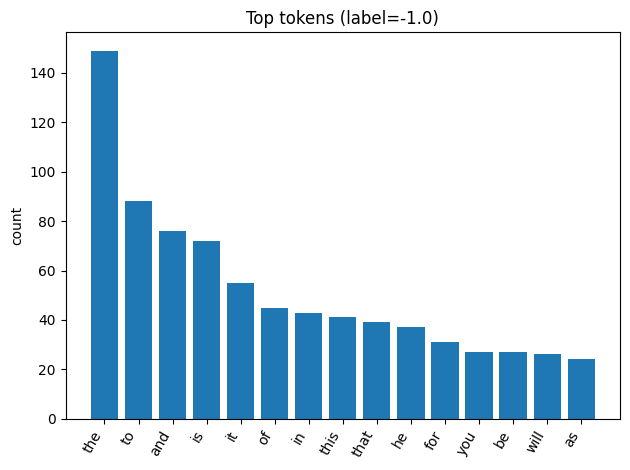

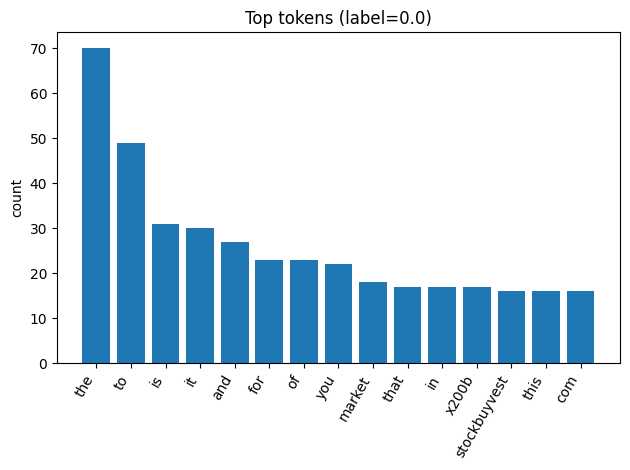

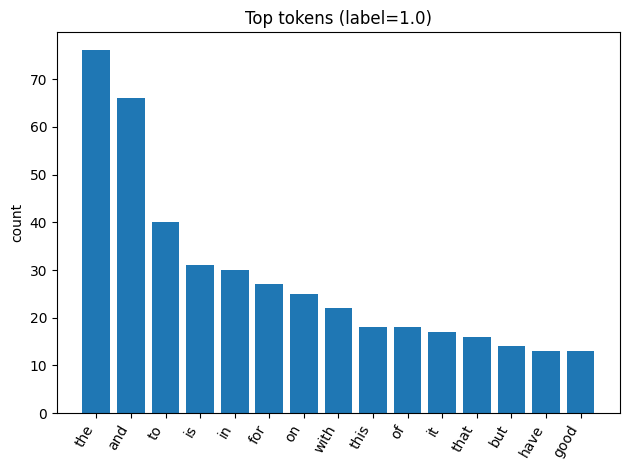

In [2]:
# -*- coding: utf-8 -*-
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from scipy import sparse


DATA_PATH = "newdataset/Reddit-stock-sentiment.csv"
MAX_SAMPLES = 5000          # 抽樣上限（避免超大資料跑太慢）
MIN_DF = 5                  # CountVectorizer 的 min_df
MAX_DF = 0.9                # CountVectorizer 的 max_df
USE_STOPWORDS = False       # 是否移除英文停用字
TOP_K_TERMS = 60            # 顯示全語料 Top K 詞
CLASS_TOPK = 15             # 各類別顯示 Top K 詞



def _ensure_csr(X):
    return X.tocsr() if sparse.isspmatrix(X) else sparse.csr_matrix(X)

def top_k_by_sum(X, vocab, k=50):
   
    X = _ensure_csr(X)
    tf = np.asarray(X.sum(axis=0)).ravel()
    order = np.argsort(-tf)
    k = min(k, len(vocab))
    top_idx = order[:k]
    terms = vocab[top_idx]
    counts = tf[top_idx]
    tf_sorted = tf[order]
    return terms, counts, tf_sorted

def top_terms_bar(terms, counts, title="Top terms", max_bar_labels=40):
    """畫出 Top terms 的條形圖。"""
    if len(terms) == 0:
        print("[top_terms_bar] 空集合，略過繪圖。")
        return
    capped = min(len(terms), max_bar_labels)
    plt.figure()
    plt.bar(range(capped), counts[:capped])
    plt.xticks(range(capped), terms[:capped], rotation=60, ha="right")
    plt.title(title)
    plt.ylabel("count")
    plt.tight_layout()
    plt.show()

def long_tail_plot(tf_sorted, title="Term frequency (sorted)"):
    """長尾圖：由大到小排序後的 term frequency。"""
    if tf_sorted is None or len(tf_sorted) == 0:
        print("[long_tail_plot] 無資料，略過繪圖。")
        return
    plt.figure()
    plt.plot(tf_sorted)
    plt.title(title)
    plt.xlabel("rank (descending by frequency)")
    plt.ylabel("term frequency")
    plt.tight_layout()
    plt.show()

def log_scaled_plot(tf_sorted, title="Log-scaled term frequency"):
    """使用 log(1+x) 縮放觀察長尾。"""
    if tf_sorted is None or len(tf_sorted) == 0:
        print("[log_scaled_plot] 無資料，略過繪圖。")
        return
    plt.figure()
    plt.plot(np.log1p(tf_sorted))
    plt.title(title)
    plt.xlabel("rank (descending by frequency)")
    plt.ylabel("log(1 + term frequency)")
    plt.tight_layout()
    plt.show()

def bar_counts(y, title="Class counts"):
    """類別分佈柱狀圖（自動忽略 NaN）。"""
    y_clean = y.dropna()
    if y_clean.empty:
        print("[bar_counts] y 皆為 NaN，略過繪圖。")
        return
    cnt = Counter(y_clean)
    keys = sorted(cnt.keys())
    vals = [cnt[k] for k in keys]
    plt.figure()
    plt.bar(range(len(keys)), vals)
    plt.xticks(range(len(keys)), [str(k) for k in keys])
    plt.title(title)
    plt.ylabel("count")
    plt.tight_layout()
    plt.show()

def top_tokens_for_class(X, y, vocab, clazz, topk=15, min_df_in_class=1):
    
    X = _ensure_csr(X)
    mask_valid = y.notna()
    X_valid = X[mask_valid.values]
    y_valid = y[mask_valid]

    pos_mask = (y_valid == clazz).values
    if pos_mask.sum() == 0:
        return np.array([]), np.array([])

    X_pos = X_valid[pos_mask]
    tf_pos = np.asarray(X_pos.sum(axis=0)).ravel()

    keep = tf_pos >= min_df_in_class
    idxs = np.where(keep)[0]
    if len(idxs) == 0:
        return np.array([]), np.array([])

    order = idxs[np.argsort(-tf_pos[idxs])]
    order = order[:min(topk, len(order))]
    terms = vocab[order]
    counts = tf_pos[order]
    return terms, counts

# =========================
# 主流程
# =========================

def main():
    # 讀取資料
    if not os.path.exists(DATA_PATH):
        raise FileNotFoundError(f"找不到資料檔：{DATA_PATH}")

    r = pd.read_csv(DATA_PATH)

    # 只保留必要欄位
    keep_cols = [c for c in r.columns if c.lower() in
                 {"text","label","sentiment","title","created_utc","subreddit","id"}]
    r = r[keep_cols].copy()

    # 將 label/sentiment 轉數值（允許 NaN）
    for c in ("label","sentiment"):
        if c in r.columns:
            r[c] = pd.to_numeric(r[c], errors="coerce")

    # 先選用 label；若缺則用 sentiment
    if "label" in r.columns:
        y = r["label"].copy()
    elif "sentiment" in r.columns:
        y = r["sentiment"].copy()
    else:
        raise ValueError("No label/sentiment column found.")

    # 同時存在且不一致：丟掉不一致的列，最後以 label 為主、用 sentiment 補空
    if {"label","sentiment"}.issubset(r.columns):
        both     = r["label"].notna() & r["sentiment"].notna()
        disagree = both & (r["label"] != r["sentiment"])
        if disagree.any():
            r = r.loc[~disagree].copy()
        y = r["label"].fillna(r.get("sentiment"))

    # 確保 text 存在且非空
    r["text"] = r["text"].astype(str).str.strip()
    r = r.loc[r["text"] != ""].copy()
    y = y.loc[r.index]  # 對齊索引

    print("Rows after cleaning:", len(r))
    print("Label distribution:\n", y.value_counts(dropna=False).sort_index())

    # 基本 EDA：字數分佈
    r["char_len"] = r["text"].str.len()
    r["word_len"] = r["text"].str.split().str.len()
    plt.figure()
    r["word_len"].plot(kind="hist", bins=50, title="Word length distribution")
    plt.xlabel("words")
    plt.tight_layout()
    plt.show()

    if len(r) > MAX_SAMPLES:
        R_sample = r.sample(n=MAX_SAMPLES, random_state=42)
    else:
        R_sample = r.copy()
    y_s = y.loc[R_sample.index]

    # ====== 向量化 ======
    stop_words = "english" if USE_STOPWORDS else None
    cv = CountVectorizer(min_df=MIN_DF, max_df=MAX_DF, stop_words=stop_words)
    R_counts = cv.fit_transform(R_sample["text"])
    vocab_r  = cv.get_feature_names_out()
    print("Reddit doc-term shape:", R_counts.shape)

    # ====== Top terms (Count) ======
    terms_r, counts_r, tf_r = top_k_by_sum(R_counts, vocab_r, k=TOP_K_TERMS)
    top_terms_bar(terms_r, counts_r, "Reddit — top terms (count)")

    # ====== 長尾與對數 ======
    long_tail_plot(tf_r, "Reddit — term frequency (sorted)")
    log_scaled_plot(tf_r, "Reddit — log-scaled term frequency")

    # ====== 類別分佈（條形圖） ======
    bar_counts(y_s, "Reddit — sentiment class counts")

    # ====== 各情緒類別的關鍵詞 ======
    if not y_s.dropna().empty:
        for clazz in sorted(y_s.dropna().unique()):
            t_, c_ = top_tokens_for_class(R_counts, y_s, vocab_r, clazz, topk=CLASS_TOPK)
            top_terms_bar(t_, c_, f"Top tokens (label={clazz})")
    else:
        print("[info] y_s 皆為 NaN，略過各類別關鍵詞分析。")

if __name__ == "__main__":
    main()


# Phase 2

In [ ]:
### Begin Assignment Here